# Visualize 2P and Behavioral Data for Mouse Decision-making Task During Virtual Navigation

In this notebook, we will demonstrate how to extract and visualize behavioral data and two-photon calcium imaging from an example file in the [Dandiset 000579](https://dandiarchive.org/dandiset/000579/0.230728.1727) based on {cite}`Tseng2020`.

#### Dataset description
The dataset contains calcium activity of >200,000 neurons recorded from 6 different cortical areas in mouse posterior cortex L2/3 and L5 using two-photon imaging, including V1 and secondary visual areas (AM and PM), retrosplenial cortex (RSC) and posterior parietal cortex (visA and MM), while the mice were performing a flexible decision-making task based on rule-switching during virtual navigation. There are total 300 behavior + imaging sessions collected from 8 mice. The neurons in each experiment have been registered into the Allen Institute Mouse Common Coordinate Framework (CCF) based on widefield retinotopy. In addition, these neurons contain fluorescent labels of retroAAV injected in one of the two sets of projection targets: an anterior part of anterior cingulate cortex/secondary motor cortex (ACC/M2) and striatum, or a posterior part of ACC/M2 and orbitofrontal cortex (OFC). 

#### Task description
The mouse ran down a virtual Y-maze and used visual cues (black or white) on the wall to guide its choice (left or right) into one of the two maze arms. After the reaching the end of the arm, the mouse was presented with a feedback delay, followed by a visual feedback indicating the correctness of its choice, and then received reward for correct trials or entered inter-trial intervals for incorrect trials (shown in B). The rewarded associations between cue and choice are determined by two rules (rule A or rule B as indicated in A), and the rule switched in blocks of 100-175 trials without explicit signaling multiple times within a single session. The mouse's performance usually dropped below chance level (fraction correct < 0.5) and recovered to expert level after 30-50 trials after rule switches (shown in C).

![virtual_navigation_schema.png](../../data/images/virtual_navigation_schema.png)

This notebook is modified from this [tutorial](https://github.com/sytseng/Tutorial_notebook_for_Dandiset_000579/blob/main/notebook/Tutorial_for_reading_NWB_files_from_Dandiset_000579.ipynb). For more information on this dataset, one can visit this [Github repository](https://github.com/sytseng/Tutorial_notebook_for_Dandiset_000579/tree/main), or a [related repo](https://github.com/sytseng/GLM_Tensorflow_2) on fitting **generalized linear models (GLM)** to the data.   

### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [1]:
import warnings
warnings.filterwarnings('ignore')

try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
%matplotlib inline

### Download file

We first download one example file from the dandiset, which contains the imaging and behavioral data for one session recorded in area A (visA).

In [3]:
dandiset_id = "000579"
dandi_filepath = "sub-9/sub-9_ses-mouse-9-session-date-2017-08-19-area-visA-L23-multi-plane-imaging_behavior+ophys.nwb"
download_loc = "."

In [4]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc)
nwb = io.read()

A newer version (0.62.2) of dandi/dandi-cli is available. You are using 0.61.2


File already exists
Opening file


### Check basic information about this session and the animal

Let's first examine some basic information about this session, including the session description, subject, surgery and virus injection sites.

In [5]:
# examine session information
nwb.experiment_description, nwb.session_id

('Mouse performing a dynamic navigation task with calcium imaging in visA layer 2/3',
 'mouse_9_session_date_2017-08-19_area_visA_L23_multi_plane_imaging')

In [6]:
# examine the subject information
nwb.subject

subject pynwb.file.Subject at 0x1319720299168
Fields:
  age__reference: birth
  date_of_birth: 2017-03-01 00:00:00-05:00
  description: Mouse 9 Askin, date of arrival 2017-04-26 (~8 weeks old; date of birth is approximated), training started on 2017-06-01
  genotype: wildtype
  sex: M
  species: Mus musculus
  strain: C57BL/6J
  subject_id: 9

In [7]:
# examine the surgery and virus information (areas and site coordinates)
nwb.surgery, nwb.virus

('cranial window creation date:2017-05-25, 3.5 mm diameter, left posterior cortex; AAVretro injection date:2017-05-25; GCaMP6s injection date:2017-07-26; performed by Shih-Yi Tseng and Selmaan N. Chettih',
 'AAV2/1-synapsin-GCaMP6s-WPRE-SV40 in left V1 x2 sites, PM x1, AM x1, MM x1, RSC x1, visA x2, 1/10 dilution, 70nl per site in L23 and 100nl per site in L5; AAV2retro-Syn-mTagBFP2 in left posterior ACC/M2 x4, undiluted, 300 nl per site, coordinate (mm from bregma): (0, L 0.35, D 0.4), (0, L 0.35, D 0.8), (0, L 0.7, D 0.3), (0, L 0.7, D 0.8); AAV2retro-Syn-mScarlet in left ORBvl x1, ORBl x1, 1/5 dilution, 500 nl per site, coordinate (mm from bregma): (A 2.65, L 0.85, D 1.8), (A 2.6, L 1.35, D 1.75)')

This mouse was implanted with a 3.5 mm craniel window over left posterior cortex. GCaMP6s was injected into 6 areas: V1, PM, AM, MM, RSC, A. In addition, these neurons contained retrograde fluorecent labels through AAVretro injection: mTagBFP2 for posterior ACC/M2 projecting neurons, and mScarlet for OFC projecting neurons. 

The information about AAVretro injuection sites can also be found in the `lab_meta_data['harvey_lab_swac_metadata_session']` :

In [8]:
# examine the AAVretro injection site for mTagBFP2
nwb.lab_meta_data['harvey_lab_swac_metadata_session'].AAVretroInjSite__mTagBFP2

'posterior_ACC_M2'

In [9]:
# examine the AAVretro injection site for mScarlet
nwb.lab_meta_data['harvey_lab_swac_metadata_session'].AAVretroInjSite__mScarlet

'OFC'

### [Optional] More on lab meta data

One can take a look at other data in the `lab_meta_data`. It contains information for `AAVretroInjSite`, `Imaging`, `Registration`, and `TaskParam`. Some of these would become useful in the later section, but there's no need to go through all of them for the purpose of this demonstration.

In [10]:
# examine the lab meta data
nwb.lab_meta_data['harvey_lab_swac_metadata_session']

harvey_lab_swac_metadata_session abc.LabMetaDataSession at 0x1319720626080
Fields:
  AAVretroInjSite__mScarlet: OFC
  AAVretroInjSite__mTagBFP2: posterior_ACC_M2
  Imaging__cortical_layer: 2/3
  Imaging__imaging_type: multi-plane
  Imaging__num_of_frame_per_volume: 5
  Imaging__num_of_imaging_plane: 4
  Registration__fov_center_ap_ccf_mm: -1.65221
  Registration__fov_center_area: visA
  Registration__fov_center_ml_ccf_mm: -1.49755
  Registration__fov_depth_mm: 0.115
  Registration__fov_plane_step_size_mm: 0.025
  Registration__fov_to_ccf_transformation_matrix: [[-1.28091964e-04 -1.46927372e-03 -1.08862203e+00]
 [ 1.33139914e-03 -1.40467401e-04 -1.95708382e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
  TaskParam__choice_bias_penalty: 0.0
  TaskParam__cue_delay_length: 10.0
  TaskParam__feedback_delay_sec: 1.0
  TaskParam__frac_non_visually_guided_trials: 0.8
  TaskParam__initial_rule: B
  TaskParam__iti_correct_sec: 2.0
  TaskParam__iti_incorrect_sec: 4.0
  TaskParam__max_position: 255.0
  TaskParam__maze_arm_length: 50.0
  TaskParam__maze_arm_width: 60.0
  TaskParam__maze_stem_length: 200.0
  TaskParam__maze_stem_width: 10.01
  TaskParam__meter_per_virmen_unit: 0.01
  TaskParam__reward_delay_sec: 3.0
  TaskParam__switches: [100 250]
  TaskParam__wall_height: 20.0

### Examine behavioral data (1): trial level information and behavioral modeling results

The task is divided into multiple trials, each of which is a single traversal through the virtual maze. The trial table in the nwb file contains basic information about these trials, including:

- `start_time`: start time of this trial from session onset in second
- `stop_time`: stop time of this trial from session onset in second
- `is_vis`: whether the trial was a visually guided trial, meaning that a visual landmark was present in the correct maze arm to guide the mouse's choice in that trial (so the mouse didn't need to use the rule to make the decision)
- `is_ruleA`: whether the trial happened during rule A; rule A: Black-Left & White-Right, rule B: White-Left & Black-Right
- `is_switch`: whether a rule switch happened on the trial
- `is_cueB`: whether the trial had a black cue; True: black, False: white
- `is_choL`: whether the mouse made a left choice on the trial; True: left, False: right
- `is_correct`: whether the trial was correct

In addition, you can also find information related to the strategy variable using trial history-based RNN models in the original paper (see {cite}`Tseng2020` for modeling details and the interpretation of these variables):
- `association_mat`: behavioral LSTM predicted conditional probability; order: P(R|W), P(L|W), P(R|B), P(L|B)
- `rule_belief`: the rule belief on the trial; directionality: positive: rule B, negative: rule A
- `signed_bias`: the signed choice bias on the trial; directionality: positive: left bias, negative: right bias
- `rule_following`: the rule-following on the trial; values between -0.5 ~ 0.5
- `bias_following`: the bias-following on the trial; between -0.5 ~ 0.5
- `prob_actual_cho`: the probability of actual choice on the trial, i.e. P(actual choice|actual cue)

[*Not super relevant for now*] Other information relate the trial onset and offset time to the imaging frames:
- `trial_onset_plane_frame_idx`: for each imaging plane, the frame index for this trial's onset
- `trial_offset_plane_frame_idx`: for each imaging plane, the frame index for this trial's offset

Let's examine the trial table:

In [11]:
# convert trial table into dataframe and examine the first 10 trials
trial_df = nwb.trials.to_dataframe()
trial_df.head(10)

,start_time,stop_time,is_vis,is_ruleA,is_switch,is_cueB,is_choL,is_correct,association_mat,rule_belief,signed_bias,rule_following,bias_following,prob_actual_cho,trial_onset_plane_frame_idx,trial_offset_plane_frame_idx
id,,,,,,,,,,,,,,,,
0,30.16975,42.57175,False,False,False,False,True,True,"[0.6423881649971008, 0.35761183500289917, 0.68...",-0.039975,-0.324752,0.019988,-0.162376,0.357612,"[120, 120, 120, 120, 120]","[162, 162, 162, 162, 161]"
1,42.59525,62.52375,False,False,False,True,True,False,"[0.25210845470428467, 0.7478915452957153, 0.55...",-0.302109,0.193674,-0.151054,0.096837,0.445783,"[195, 195, 195, 194, 194]","[271, 271, 271, 271, 270]"
2,62.55600,76.31175,False,False,False,False,True,True,"[0.34659796953201294, 0.6534020304679871, 0.36...",-0.018400,0.288404,0.009200,0.144202,0.653402,"[315, 314, 314, 314, 314]","[365, 365, 364, 364, 364]"
3,76.33225,89.94225,False,False,False,False,True,True,"[0.17578017711639404, 0.8242198824882507, 0.37...",-0.200315,0.448125,0.100158,0.224062,0.824220,"[397, 397, 397, 397, 396]","[447, 446, 446, 446, 446]"
4,89.96525,102.28325,False,False,False,False,True,True,"[0.11006782203912735, 0.8899322152137756, 0.33...",-0.225436,0.554428,0.112718,0.277214,0.889932,"[479, 479, 479, 478, 478]","[521, 520, 520, 520, 520]"
5,102.30225,116.89625,False,False,False,False,True,True,"[0.09064366668462753, 0.9093562960624695, 0.32...",-0.238642,0.580070,0.119321,0.290035,0.909356,"[553, 553, 553, 552, 552]","[608, 608, 608, 608, 607]"
6,116.92150,130.92075,False,False,False,False,True,True,"[0.08119164407253265, 0.9188083410263062, 0.32...",-0.247270,0.590347,0.123635,0.295173,0.918808,"[641, 640, 640, 640, 640]","[692, 692, 692, 692, 692]"
7,130.94750,145.18525,False,False,False,True,False,True,"[0.07719285786151886, 0.9228070974349976, 0.32...",-0.251956,0.593658,0.125978,-0.296829,0.329149,"[725, 724, 724, 724, 724]","[778, 778, 778, 777, 777]"
8,145.20575,157.87650,False,False,False,True,False,True,"[0.28123414516448975, 0.7187658548355103, 0.65...",-0.370872,0.066660,0.185436,-0.033330,0.652106,"[810, 810, 810, 810, 809]","[854, 854, 854, 853, 853]"


Let's extract some information from the trial table.

In [12]:
# extract basic trial information
cueB = trial_df['is_cueB'].values.astype(int)
choL = trial_df['is_choL'].values.astype(int)
vis = trial_df['is_vis'].values.astype(int)
ruleA = trial_df['is_ruleA'].values.astype(int)
correctness = trial_df['is_correct'].values.astype(int)
switches = np.argwhere(trial_df['is_switch'].values).flatten()

We can make a plot of task performance over the session using moving average, and see how the mouse's task performance dropped after rule switches which recovered gradually after tens of trials.

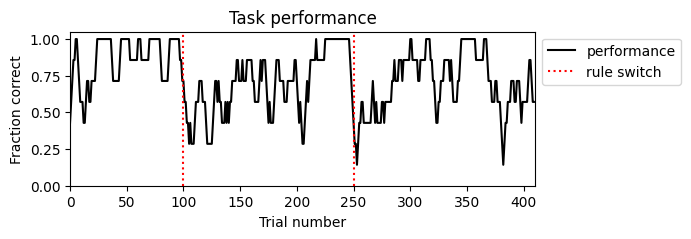

In [13]:
# get number of trials
nTrials = cueB.shape[0]

# compute moving average of correct for every 7 trials
corr_moving_avg = np.convolve(correctness, np.ones(7,)/7,mode='same')

# generate plot
plt.figure(figsize=(6,2))
plt.plot(np.arange(nTrials), corr_moving_avg,'k',label='performance')
plt.vlines(switches, ymin=0,ymax=1.05,colors='r', linestyles=':',label='rule switch')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlim([0, nTrials])
plt.ylim([0, 1.05])
plt.xlabel('Trial number')
plt.ylabel('Fraction correct')
plt.title('Task performance');

We can also extract the information about trial history RNN-derived strategy variables and make plots.

In [14]:
# extract stratey variables
association_mat = trial_df['association_mat'].values
rule_belief = trial_df['rule_belief'].values
signed_bias = trial_df['signed_bias'].values
rule_following = trial_df['rule_following'].values
bias_following = trial_df['bias_following'].values
prob_actual_cho = trial_df['prob_actual_cho'].values

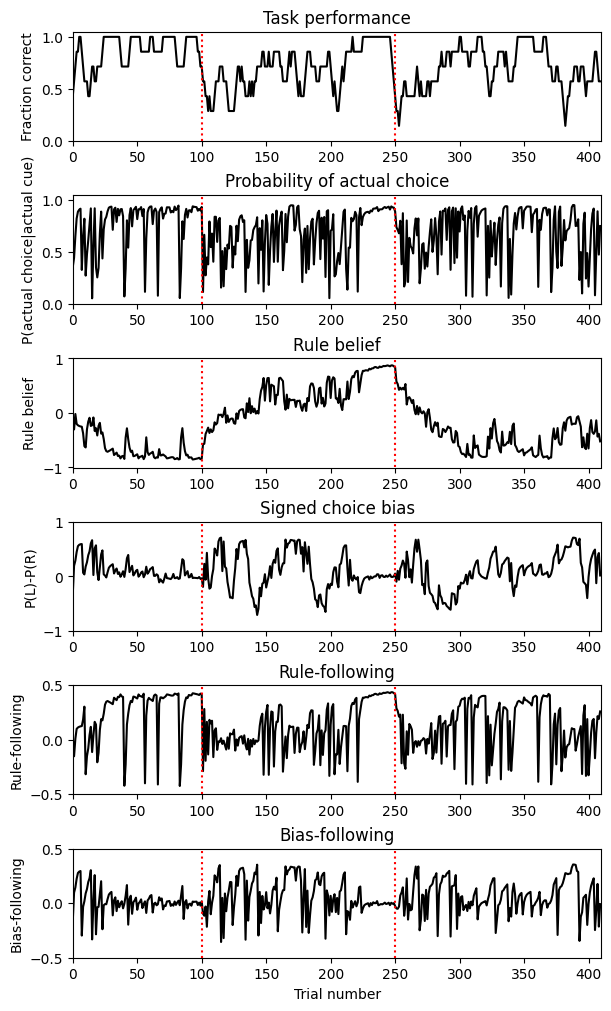

In [15]:
# make plots for strategy variables
fig, ax = plt.subplots(6,1,figsize=(6,10), constrained_layout=True)

ax[0].plot(np.arange(nTrials), corr_moving_avg, 'k')
ax[0].vlines(switches, ymin=0,ymax=1.05,colors='r', linestyles=':')
ax[0].set(xlim=[0, nTrials], ylim=[0, 1.05], ylabel='Fraction correct', title='Task performance')

ax[1].plot(np.arange(nTrials), prob_actual_cho, 'k')
ax[1].vlines(switches, ymin=0,ymax=1.05,colors='r', linestyles=':')
ax[1].set(xlim=[0, nTrials], ylim=[0, 1.05], ylabel='P(actual choice|actual cue)', title='Probability of actual choice')

ax[2].plot(np.arange(nTrials), rule_belief, 'k')
ax[2].vlines(switches, ymin=-1,ymax=1,colors='r', linestyles=':')
ax[2].set(xlim=[0, nTrials], ylim=[-1,1], ylabel='Rule belief', title='Rule belief')

ax[3].plot(np.arange(nTrials), signed_bias, 'k')
ax[3].vlines(switches, ymin=-1,ymax=1,colors='r', linestyles=':')
ax[3].set(xlim=[0, nTrials], ylim=[-1,1], ylabel='P(L)-P(R)', title='Signed choice bias')

ax[4].plot(np.arange(nTrials), rule_following, 'k')
ax[4].vlines(switches, ymin=-0.5,ymax=0.5,colors='r', linestyles=':')
ax[4].set(xlim=[0, nTrials], ylim=[-0.5,0.5], ylabel='Rule-following', title='Rule-following')

ax[5].plot(np.arange(nTrials), bias_following, 'k')
ax[5].vlines(switches, ymin=-0.5,ymax=0.5,colors='r', linestyles=':')
ax[5].set(xlim=[0, nTrials], ylim=[-0.5,0.5], xlabel='Trial number', ylabel='Bias-following', title='Bias-following');


We can see that after each rule switch, the mouse's choice bias (and bias-following) increased. As the task performance went back to stable performance, the mouse's choice bias decreased, rule belief gradually reached the correct rule with an increase in rule-following. For more details on the interpretation of these strategy variables, please refer to the original paper.

### Examine behavioral data (2): trial epoch


Epochs within the trials are labeled in the epoch table, denoting the chunking of different phases of the each trials. One can find the `start_time`, `stop_time` (both in second), and associated `trial_id` of each epoch. Every trial can be parsed into 7 epoch types (not mutually excluded):

- `maze`: when the mouse was in the maze, equals to `maze_stem` + `maze_arm`
- `maze_stem`: when the mouse was in the maze stem
- `maze_arm`: when the mouse was in the maze arm
- `feedback_delay`: when the mouse was in the feedback delay period (lasted 1 second after it reached the end of the maze arm)
- `feedback`: when the mouse was in the feedback period with the visual feedback in correct trials (lasted 2 seconds after feedback delay)
- `iti`: when the mouse was in the intertrial interval (lasted 2 seconds for correct trials and 4 seconds for inccorect trials after feedback period)
- `feedback_and_iti`: when the mouse was not in the maze, equals to `feedback_delay + feedback period + iti`

*Note that although the epochs are annotated here, there are other ways to identify each epoch which would be aligned with the imaging frames (more useful for analyzing neural data). You will see that in the following section "Useful trick: easy way to extract epoch information" in the Behavior Processing Module.*

In [16]:
# convert epoch table into dataframe and examine it
epoch_df = nwb.epochs.to_dataframe()
epoch_df.head(21)

,start_time,stop_time,epoch_type,trial_id
id,,,,
0,30.14325,37.27825,maze,0
1,30.14325,35.61125,maze_stem,0
2,35.63400,37.27825,maze_arm,0
3,37.29775,38.28250,feedback_delay,0
4,38.30750,40.28075,feedback,0
5,40.56550,42.53775,iti,0
6,37.29775,42.53775,feedback_and_iti,0
7,42.57175,55.45550,maze,1
8,42.57175,53.10850,maze_stem,1


### Examine behavioral data (3): position, velocities, and other modeling results

In the `behavior` module under the `processing` module, we can find behavioral data related to the mouse's position in the maze, their running velocities, as well as other behavioral modeling results described in {cite}`Tseng2022` quantifying the mouse's moment-by-moment decision formation (dynamic choice) and cue embodiment process (cue-biase running). These processed behavioral variables are downsampled from 2000 Hz and *aligned to the two-photon calcium imaging frames* (sampled at 30 Hz), which is useful for analyzing neural data:

- `frame_aligned_position`: Position object that contains the SpatialSeries for forward and lateral position in the maze aligned to imaging frames
- `frame_aligned_velocity`: BehavioralTimeSeries object that contains the Timeseries for velocity of the spherical treadmill (pitch, roll, yaw) aligned to imaging frames. For roll velocity, positive is left 
- `velocity_RNN_prediction_for_choice_and_cue`: BehavioralTimeSeries object that contains the Timeseries for velocity RNN prediction for moment-by-moment choice and cue, in the order of 1. choice: decoded forward in time, aka dynamic choice, 2. choice: decoded reverse in time, 3. cue: decoded forward in time, aka cue-biased running, 4. cue: decoded reverse in time (see original paper {cite}`Tseng2022` for modeling details and the interpretation of these results)


One find also find variables useful for aligning the imaging frames to trial information:
- `frame_aligned_trial_number`: Timeseries for trial number aligned to imaging frames
- `frame_aligned_time_from_choice_point`: Timeseries for time elapsed (sec) from choice point (the end of maze) aligned to imaging frames; negative: in maze, positive: during feedback and ITI
- `plane_idx_for_imaging_frames`: Timeseries for imaging plane index (for multi-plane imaging) of each imaging frame

Let's extract these variables:

In [17]:
# extract frame-aligned behavioral variables and insepct their shape
imaging_frame_timestamps = nwb.processing['behavior']['frame_aligned_position']['frame_aligned_forward_and_lateral_position'].timestamps[:]
frame_aligned_position = nwb.processing['behavior']['frame_aligned_position']['frame_aligned_forward_and_lateral_position'].data[:]
frame_aligned_velocity = nwb.processing['behavior']['frame_aligned_velocity']['frame_aligned_pitch_roll_yaw_velocity'].data[:]
frame_aligned_trial_number = nwb.processing['behavior']['frame_aligned_trial_number'].data[:]
frame_aligned_time_from_choice_point = nwb.processing['behavior']['frame_aligned_time_from_choice_point'].data[:] 
plane_idx_for_imaging_frames = nwb.processing['behavior']['plane_idx_for_imaging_frames'].data[:]

imaging_frame_timestamps.shape, frame_aligned_position.shape, frame_aligned_velocity.shape, frame_aligned_trial_number.shape, frame_aligned_time_from_choice_point.shape

((162480,), (162480, 2), (162480, 3), (162480,), (162480,))

#### Positions and velocities
We can further separate forward and lateral positions from `frame_aligned_position`, and pitch, roll, yaw velocites from `frame_aligned_velocity`. Note that the forward and lateral positions are `nan` when the mice was in feedback period/ITI.

In [18]:
# get forward and lateral positions
posF = frame_aligned_position[:,0]
posL = frame_aligned_position[:,1]

# get pitch, roll and yaw velocities
pitch = frame_aligned_velocity[:,0]
roll = frame_aligned_velocity[:,1]
yaw = frame_aligned_velocity[:,2]

#### Valid trials

Note that `frame_aligned_trial_number` contains some `nan` becuase the imaging acquisition started earlier than the onset of the task. Also, sometimes the trial number in `frame_aligned_trial_number` is not continuous because the imaging acquisition was stopped briefly (for ~10 trials) in the middle of the task for adjustment of FOV shifts due to the brain motion. (Not the case in this particular session)

One can find the "valid trials" in where corresponding imaging frames exist.

In [19]:
# identify valid trials (trials that have corresponding imaging frames)
validTrials = np.unique(frame_aligned_trial_number[~np.isnan(frame_aligned_trial_number)]).astype(int)
nValidTrials = validTrials.shape[0]

nValidTrials, nTrials

(410, 410)

#### Velocity RNN-derived variables (dynamic choice and cue-biased running)

The velocity RNN-decoded choice and cues (including dynamic choice and cue-biased running) were modeled at 6 Hz instead of 30 Hz, i.e. they were aligned to the 3rd plane of the 5 planes for multi-plane imaging sessions (or equivalently, the 3rd, 8rd, 13th, ...etc. planes for single plane imaging sessinon). These variables also contain `nan` in trials where imaging data for the whole trials were not available (due to interruption of acquisition). 

In [20]:
# extract velocity RNN-derived variables and timestamps
RNNpred_timestamps = nwb.processing['behavior']['velocity_RNN_prediction_for_choice_and_cue']['velocity_RNN_prediction_for_choice_and_cue'].timestamps[:]
velocity_RNN_prediction = nwb.processing['behavior']['velocity_RNN_prediction_for_choice_and_cue']['velocity_RNN_prediction_for_choice_and_cue'].data[:]
dynamic_choice = velocity_RNN_prediction[:,0] # dynamic choice is the choice predicted forward in time 
cue_bias_running = velocity_RNN_prediction[:,2] # cue-biased running is the cue predicted forward in time 

RNNpred_timestamps.shape, dynamic_choice.shape, cue_bias_running.shape

((32496,), (32496,), (32496,))

#### Visualization of behavioral variables

Let's create some visualization for the behavioral data. Let's first examine the raw timeseries.

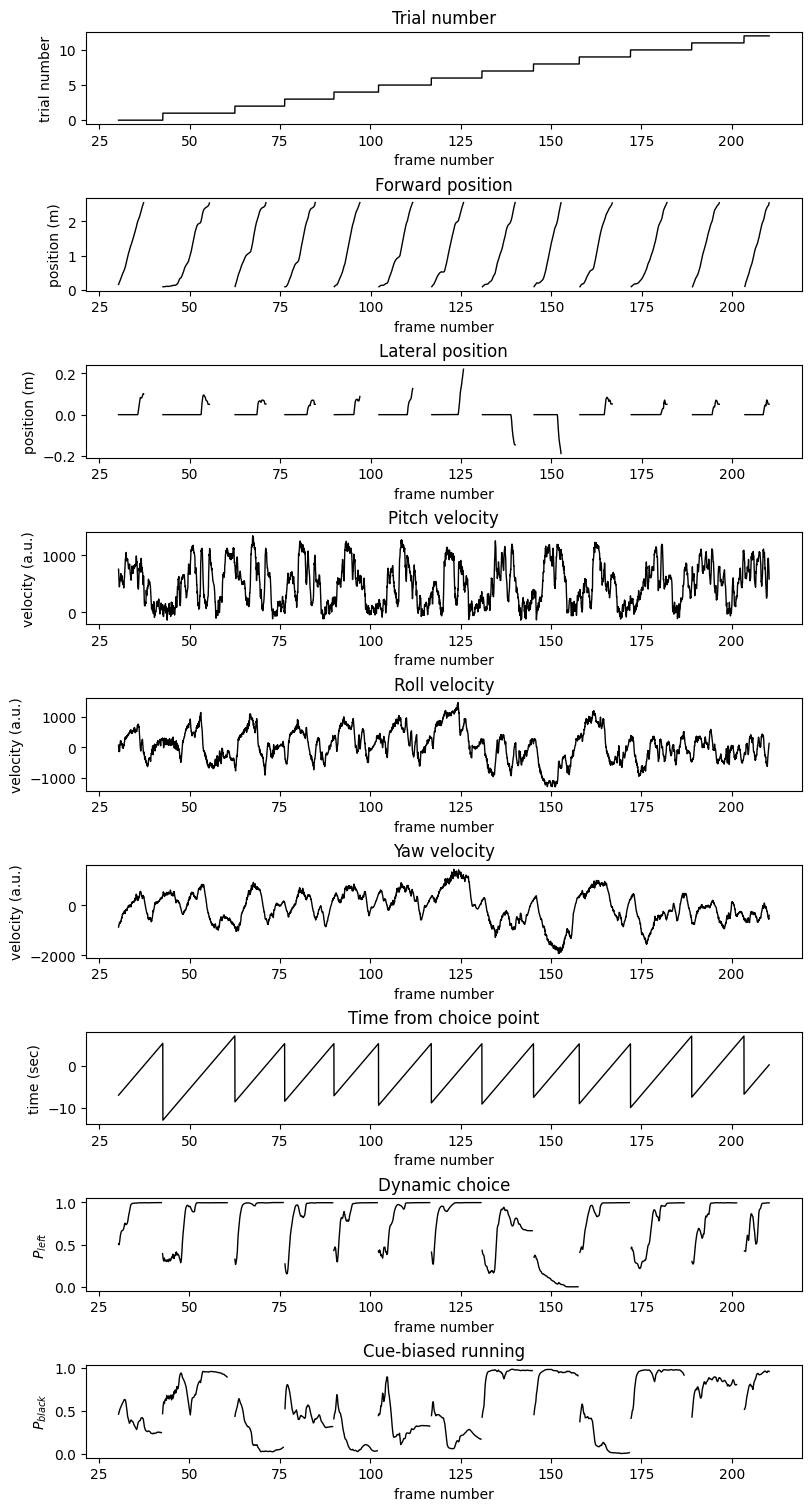

In [21]:
t_start = 600
t_end = 6000
f, ax = plt.subplots(9 , 1, figsize=(8, 15), constrained_layout=True)

ax[0].plot(imaging_frame_timestamps[t_start:t_end],frame_aligned_trial_number[t_start:t_end],'k',lw=1)
ax[0].set(xlabel = 'frame number', ylabel = 'trial number', title='Trial number')

ax[1].plot(imaging_frame_timestamps[t_start:t_end],posF[t_start:t_end],'k',lw=1)
ax[1].set(xlabel = 'frame number', ylabel = 'position (m)', title='Forward position')

ax[2].plot(imaging_frame_timestamps[t_start:t_end],posL[t_start:t_end],'k',lw=1)
ax[2].set(xlabel = 'frame number', ylabel = 'position (m)', title='Lateral position')

ax[3].plot(imaging_frame_timestamps[t_start:t_end],pitch[t_start:t_end],'k',lw=1)
ax[3].set(xlabel = 'frame number', ylabel = 'velocity (a.u.)', title='Pitch velocity')

ax[4].plot(imaging_frame_timestamps[t_start:t_end],roll[t_start:t_end],'k',lw=1)
ax[4].set(xlabel = 'frame number', ylabel = 'velocity (a.u.)', title='Roll velocity')

ax[5].plot(imaging_frame_timestamps[t_start:t_end],yaw[t_start:t_end],'k',lw=1)
ax[5].set(xlabel = 'frame number', ylabel = 'velocity (a.u.)', title='Yaw velocity')

ax[6].plot(imaging_frame_timestamps[t_start:t_end],frame_aligned_time_from_choice_point[t_start:t_end],'k',lw=1)
ax[6].set(xlabel = 'frame number', ylabel = 'time (sec)', title='Time from choice point')

# velocity RNN-derived variables are sampled at 6 Hz instead of 30 Hz
ax[7].plot(RNNpred_timestamps[t_start//5:t_end//5],dynamic_choice[t_start//5:t_end//5],'k',lw=1)
ax[7].set(xlabel = 'frame number', ylabel = '$P_{left}$', title='Dynamic choice')

ax[8].plot(RNNpred_timestamps[t_start//5:t_end//5],cue_bias_running[t_start//5:t_end//5],'k',lw=1)
ax[8].set(xlabel = 'frame number', ylabel = '$P_{black}$', title='Cue-biased running');

#### Trial-type averaged plots
To make trial-type average plots of these behavioral variables, we can first extract some useful task variables from `lab_meta_data`. The length of maze configuration is multiplied by 0.01 (the value of `meter_per_virmen_unit`) to convert from Virmen unit to meter (to be consistent with the measured position).

In [22]:
## extract important task parameters from lab meta data
# maze configuration
meter_per_virmen_unit = nwb.lab_meta_data['harvey_lab_swac_metadata_session'].TaskParam__meter_per_virmen_unit # 1 Virmen unit in the maze ~= 0.01 m
stem_length = nwb.lab_meta_data['harvey_lab_swac_metadata_session'].TaskParam__maze_stem_length*meter_per_virmen_unit
arm_length = nwb.lab_meta_data['harvey_lab_swac_metadata_session'].TaskParam__maze_arm_length*meter_per_virmen_unit

# the length of the cue delay before the maze arms (useful if you're analyzing visual response to the cue)
cue_delay_length = nwb.lab_meta_data['harvey_lab_swac_metadata_session'].TaskParam__cue_delay_length*meter_per_virmen_unit

# the length of the feedback delay in seconds
feedback_delay = nwb.lab_meta_data['harvey_lab_swac_metadata_session'].TaskParam__feedback_delay_sec

# the length of the reward delay in seconds (equals length of the feedback delay + feedback period)
reward_delay = nwb.lab_meta_data['harvey_lab_swac_metadata_session'].TaskParam__reward_delay_sec

# the length of ITI for correct and incorrect trials
iti_correct = nwb.lab_meta_data['harvey_lab_swac_metadata_session'].TaskParam__iti_correct_sec
iti_incorrect = nwb.lab_meta_data['harvey_lab_swac_metadata_session'].TaskParam__iti_incorrect_sec

Next we created position (in the maze) and temporally-binned (in feedback/ITI) velocity, such as roll velocity, for every valid trial. 

First we define a function for binning:

In [23]:
# define utility function for position and temporal binning (of single trials)
def pos_tm_binning(X, posF, time_from_cho, pos_centers, pos_half_width, tm_centers, tm_half_width):
    '''
    Bin input X by positions and time

    Input parameters::
    X: variable for binning, ndarray
    posF: position for each point in X, ndarray of shape (X.shape[0],)
    time_from_cho: time from choice point for each point in X, ndarray of shape (X.shape[0],)
    pos_centers: center locations for position bins, ndarray
    pos_half_width: half width of position center, float
    tm_centers: center locations for time bins, ndarray
    tm_half_width: half width of time bins, float

    Returns:
    X_pos: position-binned X, ndarray of shape (n_pos_bins, X.shape[1])
    X_tm: time-binned X, ndarray of shape (n_tm_bins, X.shape[1])
    '''
    # Sanity check and prelocate
    if X.ndim == 1:
        X = X.reshape(-1,1)
    X_pos = np.full((pos_centers.shape[0],X.shape[1]),np.NaN)
    X_tm = np.full((tm_centers.shape[0],X.shape[1]),np.NaN)
    
    # Calcuate position-binned X
    for pos_ind, pos_cent in enumerate(pos_centers):
        these_frames = np.logical_and(posF > (pos_cent - pos_half_width), posF < (pos_cent + pos_half_width))
        X_pos[pos_ind,:] = np.mean(X[these_frames,:], axis = 0)

    # Calcuate time-binned X  
    for tm_ind, tm_cent in enumerate(tm_centers):
        these_frames = np.logical_and(time_from_cho > (tm_cent - tm_half_width), time_from_cho < (tm_cent + tm_half_width))
        X_tm[tm_ind,:] = np.mean(X[these_frames,:], axis = 0)

    return X_pos, X_tm

We then perform spatial and temporal binning for roll velocity for all valid trials as an example (one can process the pitch and yaw velocities as well as dynamic choice and cue-biased running the same way):

In [24]:
## perform spatial and temporal binning for roll velocity for all valid trials
# select roll velocity
this_vel = roll.copy()

# set up position bins
pos_half_width = 0.1
maze_length = (stem_length + arm_length)
pos_bins = np.arange(0.1, maze_length + 0.05, pos_half_width)

# set up time bins
tm_half_width = 1/3
feedback_iti_corr_length = reward_delay + iti_correct
tm_bins = np.arange(0, feedback_iti_corr_length + 0.1, tm_half_width)

# prelocate
vel_pos = np.full((nValidTrials, pos_bins.shape[0]), np.NaN)
vel_tm = np.full((nValidTrials, tm_bins.shape[0]), np.NaN)
                             
# loop over trials for binning
for i_trial, this_trial in enumerate(validTrials):
    these_frames = frame_aligned_trial_number==this_trial
    this_pos, this_tm = pos_tm_binning(this_vel[these_frames], posF[these_frames], frame_aligned_time_from_choice_point[these_frames], 
                                       pos_bins, pos_half_width, tm_bins, tm_half_width)
    vel_pos[i_trial,:] = this_pos.flatten()
    vel_tm[i_trial,:] = this_tm.flatten()
    

# find cue and choice for valid trials
cue_valid = cueB[validTrials]
cho_valid = choL[validTrials]
trial_type = 2*cue_valid + cho_valid
trial_type_name = ['white-right','white-left','black-right', 'black-left']
trial_type_color = ['pink','skyblue','r','b']

Then we can generate plots for average roll velocity for each of the four trial types: white-right, white-left, black-right, and black-left.

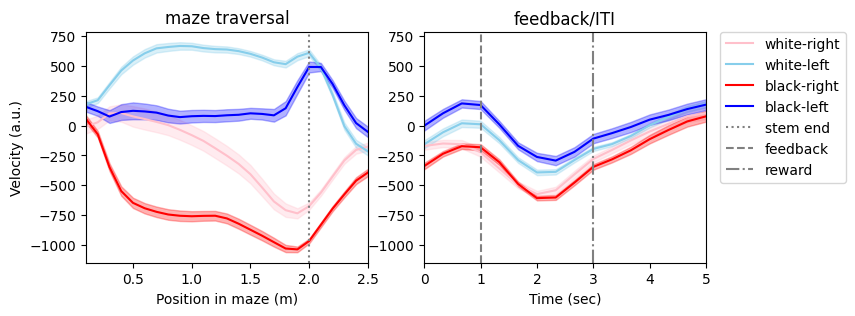

In [25]:
# plot average roll velocity (mean+-SEM)
fig, ax = plt.subplots(1,2,figsize=(8,3))
for i_type in range(4):
    this_mean_pos = np.nanmean(vel_pos[trial_type==i_type,:], axis=0)
    this_sem_pos = np.nanstd(vel_pos[trial_type==i_type,:],axis=0)/np.sqrt(np.sum(trial_type==i_type))
    ax[0].plot(pos_bins, this_mean_pos, color=trial_type_color[i_type])
    ax[0].fill_between(pos_bins, this_mean_pos-this_sem_pos, this_mean_pos+this_sem_pos, color=trial_type_color[i_type],alpha=0.3)       

    this_mean_tm = vel_tm[trial_type==i_type,:].mean(axis=0)
    this_sem_tm = vel_tm[trial_type==i_type,:].std(axis=0)/np.sqrt(np.sum(trial_type==i_type))
    ax[1].plot(tm_bins, this_mean_tm, color=trial_type_color[i_type],label=trial_type_name[i_type])
    ax[1].fill_between(tm_bins, this_mean_tm-this_sem_tm, this_mean_tm+this_sem_tm, color=trial_type_color[i_type],alpha=0.3)

y1_min, y1_max = ax[0].get_ylim()
y2_min, y2_max = ax[1].get_ylim()
ax[0].vlines(stem_length, np.min((y1_min,y2_min)), np.max((y1_max,y2_max)), color='gray', ls=':', label = 'stem end') 
ax[1].vlines(np.nan, np.min((y1_min,y2_min)), np.max((y1_max,y2_max)), color='gray', ls=':', label = 'stem end') 
ax[1].vlines(feedback_delay, np.min((y1_min,y2_min)), np.max((y1_max,y2_max)), color='gray', ls='--', label = 'feedback')  
ax[1].vlines(reward_delay, np.min((y1_min,y2_min)), np.max((y1_max,y2_max)), color='gray', ls='-.', label = 'reward') 
ax[0].set(ylim=[np.min((y1_min,y2_min)), np.max((y1_max,y2_max))], xlim=[0.1,2.5], xlabel='Position in maze (m)', ylabel='Velocity (a.u.)',title='maze traversal')
ax[1].set(ylim=[np.min((y1_min,y2_min)), np.max((y1_max,y2_max))], xlim=[0,5], xlabel='Time (sec)',title='feedback/ITI')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);


We can see that the mouse's running trajectories for left and right trials diverged early in the maze before the intersection (stem end). On top of that, the mouse also ran differently for trials with black vs. white cue, described as cue-biased running.

We can also plot traces for individual trials on top of the average to see the trial-by-trial variability:

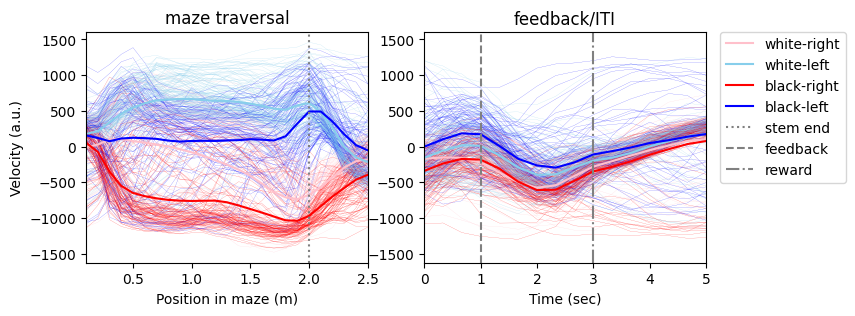

In [26]:
# plot average roll velocity with single trial traces
fig, ax = plt.subplots(1,2,figsize=(8,3))
for i_trial in range(nValidTrials):
    ax[0].plot(pos_bins, vel_pos[i_trial,:], color=trial_type_color[trial_type[i_trial]],lw=0.1)
    ax[1].plot(tm_bins, vel_tm[i_trial,:], color=trial_type_color[trial_type[i_trial]],lw=0.1)
    
for i_type in range(4):
    this_mean_pos = np.nanmean(vel_pos[trial_type==i_type,:], axis=0)
    ax[0].plot(pos_bins, this_mean_pos, color=trial_type_color[i_type])    
    this_mean_tm = vel_tm[trial_type==i_type,:].mean(axis=0)
    ax[1].plot(tm_bins, this_mean_tm, color=trial_type_color[i_type],label=trial_type_name[i_type])

y1_min, y1_max = ax[0].get_ylim()
y2_min, y2_max = ax[1].get_ylim()
ax[0].vlines(stem_length, np.min((y1_min,y2_min)), np.max((y1_max,y2_max)), color='gray', ls=':', label = 'stem end') 
ax[1].vlines(np.nan, np.min((y1_min,y2_min)), np.max((y1_max,y2_max)), color='gray', ls=':', label = 'stem end') 
ax[1].vlines(feedback_delay, np.min((y1_min,y2_min)), np.max((y1_max,y2_max)), color='gray', ls='--', label = 'feedback')  
ax[1].vlines(reward_delay, np.min((y1_min,y2_min)), np.max((y1_max,y2_max)), color='gray', ls='-.', label = 'reward') 
ax[0].set(ylim=[np.min((y1_min,y2_min)), np.max((y1_max,y2_max))], xlim=[0.1,2.5], xlabel='Position in maze (m)', ylabel='Velocity (a.u.)',title='maze traversal')
ax[1].set(ylim=[np.min((y1_min,y2_min)), np.max((y1_max,y2_max))], xlim=[0,5], xlabel='Time (sec)',title='feedback/ITI')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

### Useful trick: easy way to extract epoch information

As we see a little bit in the binning function, using these frame aligned behavioral variables, we can find the imaging frames correponding to each epoch easily (instead of using time interval information from trial table and epoch table):

In [27]:
# find corresponding imaging frames for different epochs
maze_stem_frames = np.logical_and(posF >= 0, posF < stem_length)
maze_arm_frames = np.logical_and(posF >= stem_length, posF <= maze_length)
maze_frames = np.logical_and(posF >= 0, posF <= maze_length)
feedback_delay_frames = np.logical_and(frame_aligned_time_from_choice_point >= 0, frame_aligned_time_from_choice_point < feedback_delay)
feedback_frames = np.logical_and(frame_aligned_time_from_choice_point >= feedback_delay, frame_aligned_time_from_choice_point < reward_delay)
iti_frames = frame_aligned_time_from_choice_point >= reward_delay

We can also restrict on a particular trial:

In [28]:
# find corresponding imaging frames for maze stem during trial 0 
this_trial = 0
this_trial_maze_stem_frames = np.logical_and(maze_stem_frames, frame_aligned_trial_number==this_trial)

### Examine two-photon calcium imaging data

The `ophys` module in the `processing` module of the nwb file contains data for two-photon calcium imaging, including ImageSegmentation (with neuron information in each imaging planes), deconvolved activity and dF/F. The static GCaMP/retrograde images for each imaging planes, and the vessel pattern image of this FOV taken at the top of the brain, are also included in this module.

#### Information about neurons
The `ImageSegmentation` under the ophys processing module contains `PlaneSegmentation` objects for each imaging plane (4 planes for multi-plane imaging sessions and 1 plane for single plane imaging session). Within each `PlaneSegmentation`, one can find information about each neuron recorded from this plane:
- `ml`: the coordinate along medial-lateral axis in minimeters after registration into Allen Institute's Mouse Common Coordinate Framework (CCF)
- `ap`: the coordinate along anterior-posterior axis in minimeters in CCF
- `depth`: the depth underneath the pia in minimeters 
- `area`: one of the 6 discrete cortical areas that this neuron resided in
- `mTagBFP2`: whether this neuron was labeled with mTagBFP2 (see the AAVretro injection site to know which area this neuron projected to)
- `mScarlet`: whether this neuron was labeled with mScarlet
- `pixel_mask`: the pixel mask (spatial footprint) of this neuron, in the format of [x, y, pixel intesnity] in the raw images (512 x 512)

In [29]:
# view content of ImageSegmentation
nwb.processing['ophys']['ImageSegmentation']

,ml,ap,depth,area,mTagBFP2,mScarlet,pixel_mask
id,,,,,,,
0,-1.83153,-1.67308,0.115,A,True,False,"[[483, 258, 91007.11], [482, 259, 157956.42], [483, 259, 247654.84], [484, 259, 175354.88], [481, 260, 169253.83], [482, 260, 328937.47], [483, 260, 380361.25], [484, 260, 342891.0], [485, 260, 156837.55], [480, 261, 139835.08], [481, 261, 320548.3], [482, 261, 328538.8], [483, 261, 284250.38], [484, 261, 272464.12], [485, 261, 263009.78], [486, 261, 114113.06], [479, 262, 130135.49], [480, 262, 350195.44], [481, 262, 344748.8], [482, 262, 263407.06], [483, 262, 228751.84], [484, 262, 207297.28], [485, 262, 223281.47], [486, 262, 214495.58], [479, 263, 270379.03], [480, 263, 450994.62], [481, 263, 325501.34], [482, 263, 261987.56], [483, 263, 233517.36], [484, 263, 214340.12], [485, 263, 202163.22], [486, 263, 230735.47], [479, 264, 326150.06], [480, 264, 476270.56], [481, 264, 333029.28], [482, 264, 265543.38], [483, 264, 236059.42], [484, 264, 218495.77], [485, 264, 204481.16], [486, 264, 268010.78], [487, 264, 129516.695], [478, 265, 109774.41], [479, 265, 310635.3], [480, 265, 478236.94], [481, 265, 377786.2], [482, 265, 281787.9], [483, 265, 253100.7], [484, 265, 228369.28], [485, 265, 223610.05], [486, 265, 330142.8], [487, 265, 157617.06], [479, 266, 166514.53], [480, 266, 430299.75], [481, 266, 460057.44], [482, 266, 308356.97], [483, 266, 276319.9], [484, 266, 262071.53], [485, 266, 282850.75], [486, 266, 351484.25], [480, 267, 223096.55], [481, 267, 472413.94], [482, 267, 400318.12], [483, 267, 341142.75], [484, 267, 350033.25], [485, 267, 394185.56], [486, 267, 239445.08], [481, 268, 215518.58], [482, 268, 379879.94], [483, 268, 439134.2], [484, 268, 445183.56], [485, 268, 331286.72], [482, 269, 100239.83], [483, 269, 223852.78], [484, 269, 204007.98]]"
1,-1.81635,-1.72861,0.115,A,False,True,"[[475, 217, 11779.721], [476, 217, 21893.092], [477, 217, 23192.68], [478, 217, 18077.207], [474, 218, 27621.184], [475, 218, 45044.8], [476, 218, 56738.1], [477, 218, 59457.008], [478, 218, 48369.43], [479, 218, 12665.242], [472, 219, 12816.762], [473, 219, 32254.629], [474, 219, 42073.28], [475, 219, 40477.832], [476, 219, 42192.938], [477, 219, 53071.88], [478, 219, 61973.242], [479, 219, 26224.95], [472, 220, 29170.098], [473, 220, 36263.19], [474, 220, 20734.17], [475, 220, 23104.074], [476, 220, 27555.078], [477, 220, 33960.977], [478, 220, 50999.695], [479, 220, 41034.797], [472, 221, 37479.72], [473, 221, 23905.121], [474, 221, 14156.272], [475, 221, 19098.836], [476, 221, 20715.451], [477, 221, 24270.803], [478, 221, 40262.656], [479, 221, 49374.586], [480, 221, 8807.097], [471, 222, 9034.222], [472, 222, 44253.723], [473, 222, 25068.469], [474, 222, 17174.328], [475, 222, 19703.775], [476, 222, 18325.326], [477, 222, 22856.584], [478, 222, 36802.316], [479, 222, 50652.03], [480, 222, 11847.38], [472, 223, 46447.465], [473, 223, 35605.07], [474, 223, 18739.86], [475, 223, 20567.977], [476, 223, 19826.758], [477, 223, 22451.738], [478, 223, 34963.312], [479, 223, 48713.07], [480, 223, 11620.417], [472, 224, 30984.92], [473, 224, 46513.94], [474, 224, 25852.896], [475, 224, 19138.723], [476, 224, 22233.225], [477, 224, 27827.264], [478, 224, 45244.23], [479, 224, 44777.91], [480, 224, 11101.3955], [472, 225, 9798.707], [473, 225, 42598.45], [474, 225, 43409.465], [475, 225, 34840.586], [476, 225, 36535.746], [477, 225, 42026.746], [478, 225, 45569.97], [479, 225, 33260.34], [480, 225, 8740.246], [473, 226, 15096.922], [474, 226, 31177.703], [475, 226, 39540.508], [476, 226, 38490.17], [477, 226, 33005.82], [478, 226, 24084.61], [479, 226, 17231.744], [475, 227, 17536.627], [476, 227, 11626.823]]"
2,-1.40609,-1.43519,0.115,A,False,False,"[[178, 405, 32037.309], [179, 405, 28367.28], [180, 405, 22740.55], [178, 406, 49287.418], [179, 406, 77518.414], [180, 406, 67876.07], [181, 406, 61937.824], [182, 406, 68309.266], [183, 406, 24239.715], [178, 407, 69871.7], [179, 407, 72018.234], [180, 407, 56953.594], [181, 407, 56053.12], 

There are 4 imaging planes in this session (PlaneSegmentation_0 to 3). We can extract the information of the first PlaneSegmentation. 

*Note that although this imaging FOV was centered on the brain area visA, some neurons were labeled to be in retrosplenial cortex (RSC), because we classified each neuron's location based on post hoc registration using anatomical and retinotopy information.*

In [30]:
# convert the first PlaneSegmentation into dataframe and examine the information
planeSeg_0_df = nwb.processing['ophys']['ImageSegmentation']['PlaneSegmentation_0'].to_dataframe()
planeSeg_0_df.head(20)

,ml,ap,depth,area,mTagBFP2,mScarlet,pixel_mask
id,,,,,,,
0,-1.83153,-1.67308,0.115,A,True,False,"[[483, 258, 91007.11], [482, 259, 157956.42], ..."
1,-1.81635,-1.72861,0.115,A,False,True,"[[475, 217, 11779.721], [476, 217, 21893.092],..."
2,-1.40609,-1.43519,0.115,A,False,False,"[[178, 405, 32037.309], [179, 405, 28367.28], ..."
3,-1.35358,-1.47856,0.115,A,True,False,"[[146, 371, 16934.56], [147, 371, 34940.188], ..."
4,-1.33481,-1.46609,0.115,A,False,False,"[[136, 379, 49693.73], [134, 380, 106279.6], [..."
5,-1.39399,-1.43513,0.115,A,False,False,"[[171, 407, 129510.016], [172, 407, 175824.52]..."
6,-1.80346,-1.75859,0.115,A,False,False,"[[470, 192, 61868.5], [471, 192, 107326.45], [..."
7,-1.42985,-1.66434,0.115,A,False,False,"[[210, 238, 121663.39], [211, 238, 87916.88], ..."
8,-1.48183,-1.45869,0.115,A,False,False,"[[232, 395, 18493.646], [233, 395, 28247.006],..."


#### Visualize pixel masks for neurons
We can visualize the pixel masks for all neurons in this imaging plane:

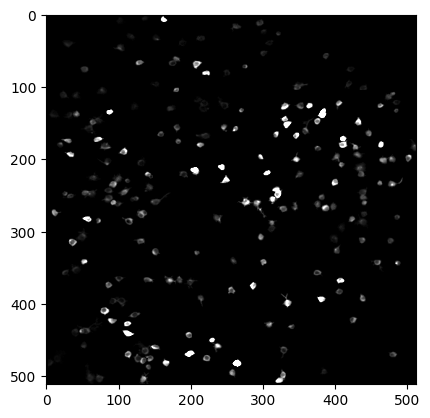

In [31]:
# extract information for these neurons in plane 0
ml_0 = planeSeg_0_df['ml'].values
ap_0 = planeSeg_0_df['ap'].values
depth_0 = planeSeg_0_df['depth'].values
area_0 = planeSeg_0_df['area'].values
mTagBFP2_0 = planeSeg_0_df['mTagBFP2'].values
mScarlet_0 = planeSeg_0_df['mScarlet'].values

# compute number of neurons in this plane
n_neurons_0 = ml_0.shape[0]

# overlay pixel masks for all sources in plane 0
source_img = np.zeros((512,512)) # the imaging FOV was 512 x 512

for i_neuron in range(n_neurons_0):
    n_pixels = planeSeg_0_df['pixel_mask'][i_neuron].shape[0]
    for i_pixel in range(n_pixels):
        x, y, w = planeSeg_0_df['pixel_mask'][i_neuron][i_pixel]
        source_img[x,y] += w
        
# display the overlay image
plt.imshow(source_img, vmax = np.percentile(source_img[:],99.5) ,cmap='gray');

#### Extract neural activity (dF/F and deconvolved activity)

For each `PlaneSegmentation`, there is a corresponding `deconvolved_activity` and a `df_over_f` object that have the `RoiResponseSeries` for the deconvolved activity and dF/F timeseries for all neurons in that imaging plane. They share the same timestamps.

In [32]:
# extract data from deconvolved_activity_plane_0 and inspect their shape
imaging_timestamps_0 = nwb.processing['ophys']['deconvolved_activity_plane_0'].timestamps
deconv_0 = nwb.processing['ophys']['deconvolved_activity_plane_0'].data[:]
df_0 = nwb.processing['ophys']['df_over_f_plane_0']['dF_over_F_plane_0'].data[:]

imaging_timestamps_0.shape, deconv_0.shape, df_0.shape, n_neurons_0

((32496,), (32496, 224), (32496, 224), 224)

#### Visualization  of neural activity

First we can examine the raw timeseries of the dF/F and deconvloved activity of some neurons. Here we z-score the neural activity for visualization.

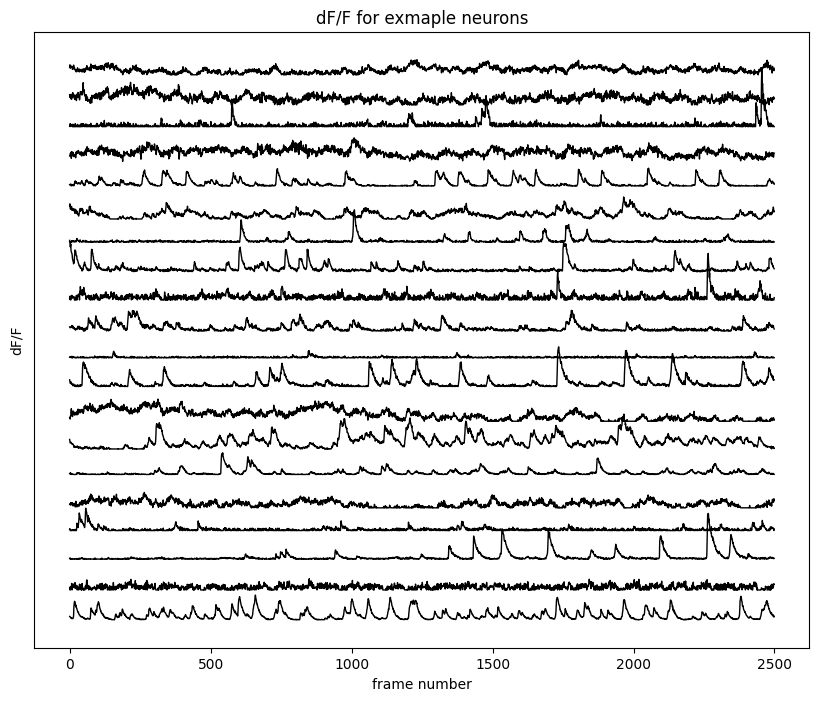

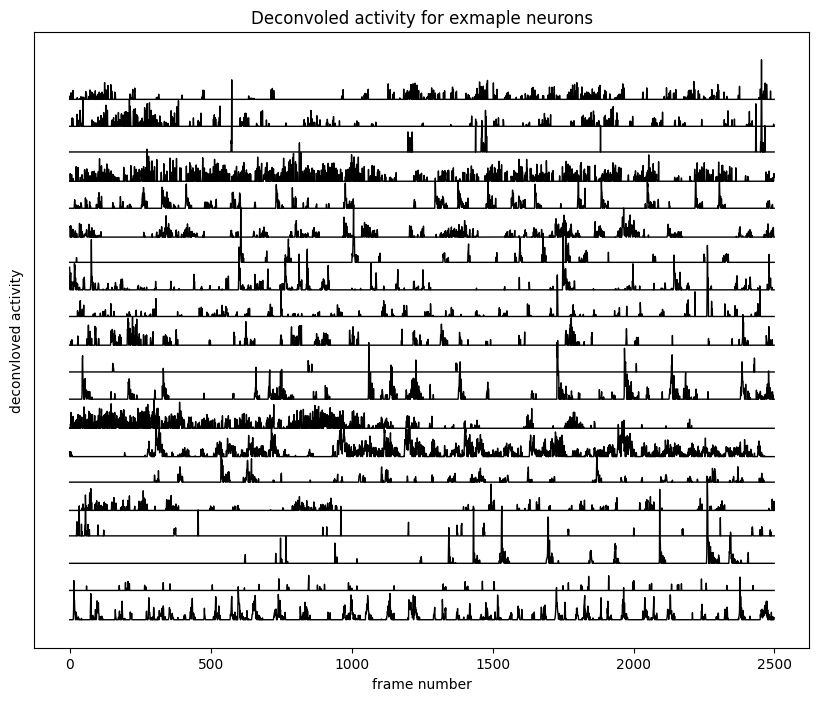

In [33]:
# plot z-scored dF/F and deconvoled activity for the first 20 neurons in this imaging plane
n_selected_neurons = 20
frame_start = 1000
n_frames = 2500
df_z = zscore(df_0, axis=0)
deconv_z = zscore(deconv_0, axis=0)

fig, ax = plt.subplots(1,1,figsize = (10,8))
ax.plot(np.arange(n_frames), df_z[frame_start:frame_start+n_frames, :n_selected_neurons]+5*np.arange(n_selected_neurons),'k',lw=1)
ax.set(xlabel='frame number', yticks=[], ylabel='dF/F',title='dF/F for exmaple neurons');

fig, ax = plt.subplots(1,1,figsize = (10,8))
ax.plot(np.arange(n_frames), deconv_z[frame_start:frame_start+n_frames, :n_selected_neurons]+5*np.arange(n_selected_neurons),'k',lw=1)
ax.set(xlabel='frame number', yticks=[], ylabel='deconvloved activity',title='Deconvoled activity for exmaple neurons');

### Combine 2P imaging and behavioral data

Now we are ready to combine the neural activity and behavioral variables to explore their relationship. But just before this, there's a final piece of processing to align behavioral timeseries to timestamps for individual imaging planes.

#### Aligning behavioral timeseries to individual imaging plane
Remember that the behavioral timeseries were downsampled to match the original imaging sampling rate at 30 Hz. However, for multi-plane imaging sessions, there are 5 planes per "volume" (4 imaging planes + 1 flyback frame), so the sampling rate for each plane is 30/5 = 6 Hz. To find the corresponding behavioral timeseries aligned to the imaging frames of each imaging plane, we can use (1) the `plane_idx_for_imaging_frames` (previously described in the behavior processingmodule) or (2) regular spacing for indexing those behavioral timeseries. In this way, we can avoid complicated alignment through the timestamps stored in those objects, although the information is present in the nwb.

In [34]:
# use plane_idx_for_imaging_frames to identify behavioral variables corresponding to this imaging plane
nPlane = 0
frame_idx_0 = plane_idx_for_imaging_frames == nPlane
trial_number_0 = frame_aligned_trial_number[frame_idx_0]
posF_0 = posF[frame_idx_0]
time_from_choice_point_0 = frame_aligned_time_from_choice_point[frame_idx_0]

In [35]:
# alternatively, use regular spacing for every 5 planes
n_planes = 5
trial_number_0 = frame_aligned_trial_number[nPlane::n_planes]
posF_0 = posF[nPlane::n_planes]
time_from_choice_point_0 = frame_aligned_time_from_choice_point[nPlane::n_planes]

#### Examine trial-type averaged activity 
Now we can bin the deconvolved activity of the neurons into spatial (in the maze) and temporal (during feedback/ITI) bins for every trial.

In [36]:
# position and temporal binning for deconvolved activity
activity_pos = np.full((nValidTrials, pos_bins.shape[0], n_neurons_0), np.NaN)
activity_tm = np.full((nValidTrials, tm_bins.shape[0], n_neurons_0), np.NaN)
                             
for i_neuron in range(n_neurons_0):
    for i_trial, this_trial in enumerate(validTrials):
        these_frames = trial_number_0==this_trial
        this_pos, this_tm = pos_tm_binning(deconv_0[these_frames,i_neuron], posF_0[these_frames], time_from_choice_point_0[these_frames], 
                                           pos_bins, pos_half_width, tm_bins, tm_half_width)
        activity_pos[i_trial,:,i_neuron] = this_pos.flatten()
        activity_tm[i_trial,:,i_neuron] = this_tm.flatten()

We can plot trial-type average deconvolved activity for some selected neurons, which shows us how these neurons change their activity according to different trial types (cue-choice combination) and trial phases (position in the maze or time in feedback/ITI).

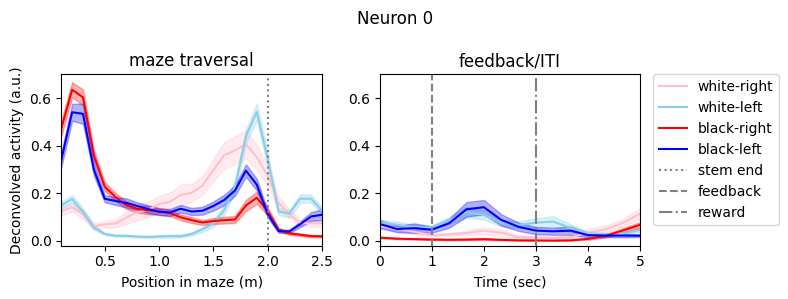

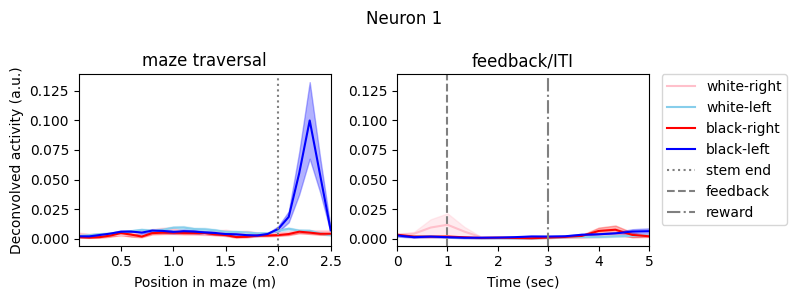

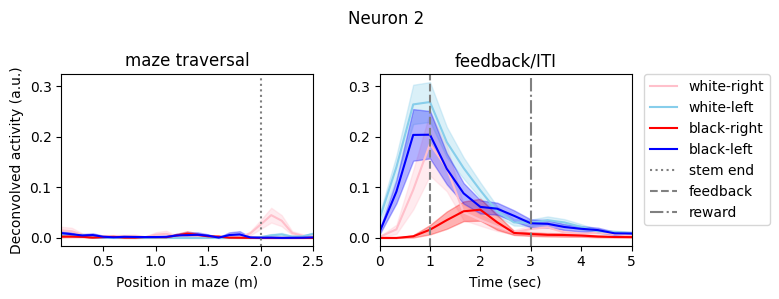

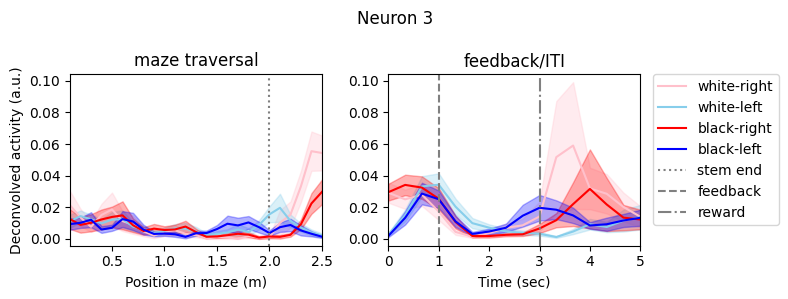

In [37]:
# plot trial-type average deconvolved activity for 4 selected neurons (mean+-SEM) 
for i_neuron in range(4):
    fig, ax = plt.subplots(1,2,figsize=(8,3))
    for i_type in range(4):
        this_mean_pos = np.nanmean(activity_pos[trial_type==i_type,:,i_neuron], axis=0)
        this_sem_pos = np.nanstd(activity_pos[trial_type==i_type,:,i_neuron],axis=0)/np.sqrt(np.sum(trial_type==i_type))
        ax[0].plot(pos_bins, this_mean_pos, color=trial_type_color[i_type])
        ax[0].fill_between(pos_bins, this_mean_pos-this_sem_pos, this_mean_pos+this_sem_pos, color=trial_type_color[i_type],alpha=0.3)       

        this_mean_tm = activity_tm[trial_type==i_type,:,i_neuron].mean(axis=0)
        this_sem_tm = activity_tm[trial_type==i_type,:,i_neuron].std(axis=0)/np.sqrt(np.sum(trial_type==i_type))
        ax[1].plot(tm_bins, this_mean_tm, color=trial_type_color[i_type],label=trial_type_name[i_type])
        ax[1].fill_between(tm_bins, this_mean_tm-this_sem_tm, this_mean_tm+this_sem_tm, color=trial_type_color[i_type],alpha=0.3)

    y1_min, y1_max = ax[0].get_ylim()
    y2_min, y2_max = ax[1].get_ylim()
    ax[0].vlines(stem_length, np.min((y1_min,y2_min)), np.max((y1_max,y2_max)), color='gray', ls=':', label = 'stem end') 
    ax[1].vlines(np.nan, np.min((y1_min,y2_min)), np.max((y1_max,y2_max)), color='gray', ls=':', label = 'stem end') 
    ax[1].vlines(feedback_delay, np.min((y1_min,y2_min)), np.max((y1_max,y2_max)), color='gray', ls='--', label = 'feedback')  
    ax[1].vlines(reward_delay, np.min((y1_min,y2_min)), np.max((y1_max,y2_max)), color='gray', ls='-.', label = 'reward') 
    ax[0].set(ylim=[np.min((y1_min,y2_min)), np.max((y1_max,y2_max))], xlim=[0.1,2.5], xlabel='Position in maze (m)', ylabel='Deconvolved activity (a.u.)',title='maze traversal')
    ax[1].set(ylim=[np.min((y1_min,y2_min)), np.max((y1_max,y2_max))], xlim=[0,5], xlabel='Time (sec)',title='feedback/ITI')
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    fig.suptitle(f'Neuron {i_neuron}')
    fig.tight_layout()

At first glance, we can observe diverse activity patterns for these neurons. Some of them showed high activity only at a particular trial phase (maze position or time in feedback/ITI). On top of the trial phase-specificity, their activity were also modulated/multiplexed by trial type: cue, choice, or a combination of both. Here we cannot present additional tuning such as tuning to reward or running velocities. For a more comprehensive study of each neuron's tuning properties over a large spectrum of task and behavioral variables, one can use more complicated statistical methods, such as generalized linear models (GLM).

#### View static images

In the ophys processing module, you can also find `static_GCaMP_and_retrograde_label_image` for each imaging plane and `vessel_img` as the vessel pattern at brain surface for this FOV.

In [38]:
# view content of the static images for plane 0
nwb.processing['ophys']['static_GCaMP_and_retrograde_label_image_plane_0']

static_GCaMP_and_retrograde_label_image_plane_0 pynwb.base.Images at 0x1319720300656
Fields:
  description: static unmixed images for GCaMP and retrograde labels of the FOV
  images: {
    GCaMP_800nm <class 'pynwb.image.GrayscaleImage'>,
    GCaMP_850nm <class 'pynwb.image.GrayscaleImage'>,
    mScarlet_800nm <class 'pynwb.image.GrayscaleImage'>,
    mTagBFP2_850nm <class 'pynwb.image.GrayscaleImage'>
  }

Let's extract static images for this imaging plane and visualize them:

In [39]:
# extract static images for this imaging plane
# (GCaMP image acquired at 850 nm shows the anatomical image)
GCaMP_img = nwb.processing['ophys']['static_GCaMP_and_retrograde_label_image_plane_0']['GCaMP_850nm'].data[:]
mScarlet_img = nwb.processing['ophys']['static_GCaMP_and_retrograde_label_image_plane_0']['mScarlet_800nm'].data[:]
mTagBFP2_img = nwb.processing['ophys']['static_GCaMP_and_retrograde_label_image_plane_0']['mTagBFP2_850nm'].data[:]
vessel_img = nwb.processing['ophys']['vessel_img']['vessel_img'].data[:]

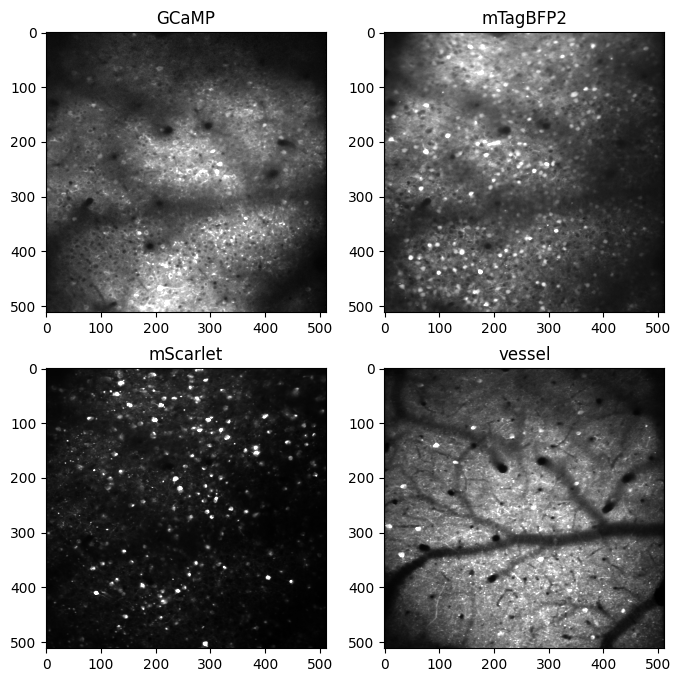

In [40]:
# visualize the static images
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0,0].imshow(GCaMP_img, vmax = np.percentile(GCaMP_img[:], 99.5), cmap='gray')
ax[0,0].set(title = 'GCaMP')
ax[0,1].imshow(mTagBFP2_img, vmax = np.percentile(mTagBFP2_img[:], 99.5), cmap='gray')
ax[0,1].set(title = 'mTagBFP2')
ax[1,0].imshow(mScarlet_img, vmax = np.percentile(mScarlet_img[:], 99.5), cmap='gray')
ax[1,0].set(title = 'mScarlet')
ax[1,1].imshow(vessel_img, vmax = np.percentile(vessel_img[:], 99.5), cmap='gray')
ax[1,1].set(title = 'vessel');